In [36]:
#Import libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
import numpy as np
import shap

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder

# <div style="background-color:#00357A; padding:20px; border-radius:10px; color:white; width:auto;">Executive Summary</div>

St. James Hospital’s “Baby Monitor” ML model produced misclassifications of newborn risk leading to patient fatality. The model’s unreliability and lack of transparency have jeopardized patient safety and eroded the trust of the hospital staff. The Organization for Whitebox ModeLs (OWL) was commissioned to diagnose the model’s failures and propose a safer and more transparent alternative. The objective is to deliver a reliable predictive model and a governance framework that ensures clear explanations and effective human oversight

When evaluating the original model, we found critical flaws. The main flaw of the system is it prioritized precision over recall, an evaluation metric that is optimized for hospital efficiency rather than patient safety, resulting in a low 57.1% recall rate for at-risk infants. In contrast, a new decision tree model achieved a 99% recall rate, providing a more reliable model alternative. 

To ensure long-term model safety and effectiveness, we have 2 recommendations. First is St. James Hospital should continuously improve the model’s generalizability by expanding and diversifying the dataset with data from other hospitals and diverse demographic regions. Second is we advice implementing advanced class balancing techniques, exploring and combining various sampling methods to enhance the performance and transparency of all models, which will further reduce the risk of misclassification.


# <div style="background-color:#00357A; padding:20px; border-radius:10px; color:white; width:auto;">I. Introduction</div>

## <div style="background-color:#0081CC; padding:10px; border-radius:10px; color:white; width:auto;">Overview</div>

The Organization for Whitebox ModeLs (OWL) was commissioned by St. James Hospital to audit the Baby Monitor Project, an AI-based system developed by Data Monitors for the hospital’s OB-GYN department. The system was designed to predict newborn risk levels and support staff in providing timely care.

Although the project initially showed strong results in improving efficiency and patient satisfaction, a series of misclassifications, one of which resulted in a fatality, prompted serious concerns regarding the model’s accuracy and transparency.

This report summarizes OWL’s independent assessment of the Baby Monitor model and outlines findings, issues, and recommendations to guide St. James Hospital in strengthening the safety, reliability, and governance of future AI solutions.



## <div style="background-color:#0081CC; padding:10px; border-radius:10px; color:white; width:auto;">Problem</div>

1.How did the erroneous model make its predictions?

2.What features contributed to the misclassification of the 12 babies, what do these reveal about the model’s decision making process?

3.How can Data Monitors improve its preprocessing, modelling, and metrics to improve model detection and interpretability? 

4.What strategies can be implemented into a framework to ensure ongoing human involvement and effective risk mitigation while using the machine learning model?


## <div style="background-color:#0081CC; padding:10px; border-radius:10px; color:white; width:auto;">Project Objectives</div>

This assessment aims to tackle two main objectives. The first objective is to investigate and interpret the erroneous model. Interpreting the model allows the OWL and St. James Hospital to discover the logic behind its predictions, cross-reference the findings with healthcare practitioners, and troubleshoot faulty steps in preprocessing the data and training the model. This entails understanding the behavior of the model, particularly in detecting most prominent patterns in predicting the health of the 12 misclassified babies to see where the model went wrong.

The second objective is to propose a better model and framework that reduces the risks of misclassifications and ensures that any errors are quickly detected and mitigated. The new machine learning model must be able to transparently provide clean explanations for its decisions. The framework also entails seamlessly integrating the model into the workflow and educating stakeholders on proper intervention. This framework will serve as a template for future machine learning modeling efforts.


## <div style="background-color:#0081CC; padding:10px; border-radius:10px; color:white; width:auto;">Significance of the Report</div>

Explainable models and robust decision-making frameworks are necessary to develop trust between doctors, nurses, and patients. Machine learning is a powerful tool to detect complex relationships and patterns. When used correctly, it can help medical practitioners become more efficient in their tasks and provide better patient care. However, integrating machine learning in decision-making entails responsibility and accountability. In the context of healthcare, one wrong mistake can lead to the loss of one’s life. Machine learning models need to be transparent so that medical practitioners can make informed decisions in communicating health concerns to the patient and providing personalized treatment. 



# <div style="background-color:#00357A; padding:20px; border-radius:10px; color:white; width:auto;">II. Methodology</div>

The methodology is as follows:

1. Data Collection 
    Data was provided of St. James Hospital’s historical records for 70 babies. Exploratory Data Analysis will be used to understand the dataset: duplicate values, distributions for each feature, and other patterns present with the data. 

2. Evaluation of Data Monitor’s Model
    The original model, its specification, and its accuracies (recall, precision, accuracy), were also provided by St. James Hospital. The models were run to identify the model’s current classification report. Preprocessing steps were analyzed and implied based on the model specifications and parameters. Then, the pre-processing, modelling, and evaluation metrics were critiqued. 

3. Analysis of the Misclassified Babies
    SHAP was used to analyze the decisions behind classifying the 12 babies as healthy. By applying SHAP on both an individual instance and a group instance, stakeholders can recognize which features have a large influence on the final prediction and lead to the misclassification.

4. Improved Model
	Given the previous observations, the team suggests more appropriate preprocessing methods, model types, and evaluation metrics for detecting and classifying newborn risk levels. The new model will also be interpreted through SHAP to showcase the contribution of each feature to this new model’s predictions, and particularly in discrepancies that possibly misclassified the 12 false negatives. 

5. Robust Framework 
    Finally, the team suggests ways to seamlessly integrate the system into the hospital’s workflow. The framework allows for human intervention so that errors are easily mitigated. 


# <div style="background-color:#00357A; padding:20px; border-radius:10px; color:white; width:auto;">III. Data Description</div>

The following features are contained within the ```historical.csv```. The dataset has a shape of 2,100 rows and 25 columns:


<div align="center">

| **Feature Name**              | **Feature Description**                            | **Data Type** |
| :----------------------------: | :------------------------------------------------: | :------------: |
| `baby_id`                     | Unique identifier for each baby                    | string        |
| `name`                        | Name of the baby                                   | string        |
| `gender`                      | Gender of the baby (Male/Female)                   | string        |
| `gestational_age_weeks`       | Gestational age at birth (normal: 37–42 weeks)     | float         |
| `birth_weight_kg`             | Weight of the baby at birth (normal: 2.5–4.5 kg)   | float         |
| `birth_length_cm`             | Length of the baby at birth (average: 48–52 cm)    | float         |
| `birth_head_circumference_cm` | Head circumference at birth (average: 33–35 cm)    | float         |
| `date`                        | Monitoring date                                    | string (date) |
| `age_days`                    | Age of the baby in days since birth                | integer       |
| `weight_kg`                   | Recorded daily weight                              | float         |
| `length_cm`                   | Recorded daily body length                         | float         |
| `head_circumference_cm`       | Recorded daily head circumference                  | float         |
| `temperature_c`               | Body temperature in °C (normal: 36.5–37.5)         | float         |
| `heart_rate_bpm`              | Heart rate (normal: 120–160 bpm)                   | integer       |
| `respiratory_rate_bpm`        | Respiratory rate (normal: 30–60 bpm)               | integer       |
| `oxygen_saturation`           | Oxygen saturation level (normal >95%)              | integer       |
| `feeding_type`                | Type of feeding: Breastfeeding, Formula, or Mixed  | string        |
| `feeding_frequency_per_day`   | Number of feeds per day (normal: 8–12)             | integer       |
| `urine_output_count`          | Wet diaper count per day (normal: 6–8+)            | integer       |
| `stool_count`                 | Bowel movements per day (0–5 typical)              | integer       |
| `jaundice_level_mg_dl`        | Bilirubin level (normal <5, mild 5–12, severe >15) | float         |
| `apgar_score`                 | APGAR score at birth (0–10, recorded on day 1)     | float         |
| `immunizations_done`          | Immunizations completed (Yes/No)                   | string        |
| `reflexes_normal`             | Whether newborn reflexes are normal (Yes/No)       | string        |
| `risk_level`                  | Target variable: Healthy (0) or At Risk (1)        | string        |

</div>


With the `risk_level` being the target feature for the model.

# <div style="background-color:#00357A; padding:20px; border-radius:10px; color:white; width:auto;">IV. Exploratory Data Analysis</div>

This section explores the Baby Monitor dataset to understand its structure and key characteristics before model evaluation. The analysis focuses on identifying trends, distributions, and anomalies in newborn health metrics, as well as checking for missing data or imbalances that could affect model performance.

<div style="text-align: center;">
    <img src="https://imgur.com/1MUZBek.png" alt="Gender Distribution" width="450">
</div>

<div style="text-align: center;">
    <img src="https://imgur.com/lQ6TWRv.png" alt="Birth Weight by Gender" width="700">
</div>


### **Gender Distribution (Pie Chart)**

This chart shows the percentage of males and females the dataset. It indicates that the sample distribution is 55.7% males and 44.3% females.

***

### **Birth Weight by Gender (Box Plot)**

This chart compares the distribution of birth weights between male and female infants. It shows that both genders have a very similar median birth weight which is around 3.2 kg. The overall spread of the birth weights is also very comparable for both groups, suggesting that there isn't a significant difference in birth weight between males and females in the data.

<div style="text-align: center;">
    <img src="https://imgur.com/wSJXn0Y.png" alt="Distribution of Jaundice Levels" width="700">
</div>


### **Distribution of Jaundice Levels (Histogram)** 
The distribution of jaundice levels using a histogram reveals a bimodal pattern. The primary and larger peak indicates that a majority of the subjects have jaundice levels concentrated around 3-4 mg/dL. A second, smaller peak is also evident in the 9-11 mg/dL range, representing a smaller but significant subgroup with elevated levels. The overall distribution is skewed to the right, which points to the presence of a minority of individuals with exceptionally high jaundice levels.

<div style="text-align: center;">
    <img src="https://imgur.com/DoxSI0T.png" alt="Average Vital Signs Over Time" width="700">
</div>


### **Average Vital Signs Over Time (Line Graphs)** 

The line graphs displays the average daily trends for four vital signs—temperature, heart rate, respiratory rate, and oxygen saturation—over a 30-day period. All four metrics exhibit daily fluctuations without a long-term upward or downward trend. While temperature remains relatively stable, both heart rate and respiratory rate show more pronounced day-to-day variability. Oxygen saturation also fluctuates daily but stays within a consistent range. Overall, the graph indicates that despite short-term variations, the vital signs stayed generally steady throughout the entire month.

# <div style="background-color:#00357A; padding:20px; border-radius:10px; color:white; width:auto;">V. Evaluation of Data Monitor’s Model</div>

Data Monitor provided St. James’ Hospital with a model that acts as a Baby Monitor for the OBGYN Ward. The model provides a daily prediction of whether the baby is healthy or at risk based on various factors. It preprocessed the data based on its data type and ensured that each feature was understood by the machine. Then, it used Logistic Regression to learn and identify patterns within the dataset. Finally, Alberto used precision as his evaluation metric to assess the performance of his model.


## <div style="background-color:#0081CC; padding:10px; border-radius:10px; color:white; width:auto;">Pre-Processing</div>

After conducting a thorough exploratory data analysis of each of the columns, it is evident that all the features followed a normal distribution. This indicates that the data is relatively well-balanced across value ranges, which helps ensure stable model training.  This holds true for models sensitive to feature scaling, such as Logistic Regression and SVM. Therefore, knowing that they would use Logistic Regression to model their data, it was right for Alberto to use a scaling feature to ensure that all variables contribute proportionally to the model and improve the stability and efficiency of the training process. 

However, what Alberto failed to look at was whether the target column was perfectly balanced. Imbalanced datasets have difficulty capturing patterns of the smaller class, which in this case is those babies “at risk”. Therefore, this could have made it difficult for the model to classify the false-negative babies


## <div style="background-color:#0081CC; padding:10px; border-radius:10px; color:white; width:auto;">Modeling</div>

Logistic Regression is a classification model that uses a sigmoid or an S-shaped curve to predict the probability that a certain object belongs to a certain class. In this case, it is whether the baby is ‘healthy’ or ‘at risk.’ However, there are more complex models that we could explore to provide better results.

## <div style="background-color:#0081CC; padding:10px; border-radius:10px; color:white; width:auto;">Evaluation Metric</div>

Precision is a good metric to use if our main concern were to prevent babies from being mislabelled “at risk.” Although using this metric would be good for the efficiency of the hospital, a better evaluation metric would be recall because we want to prevent deaths and ensure we correctly prioritize the babies who need it most. Using the model to evaluate the data set, it scored a test accuracy of 91.9%, a precision of 76.2% and a recall of 57.1%. 


# <div style="background-color:#00357A; padding:20px; border-radius:10px; color:white; width:auto;">VI. SHAP</div>

To explain why the babies were misclassified, this section will use Shapley Additive Explanations (SHAP) to explore individual instances and group instances that could have led to misclassifying these babies as ‘healthy’. SHAP uses Shapley values to identify how each feature contributed to the outcome. 

## <div style="background-color:#0081CC; padding:10px; border-radius:10px; color:white; width:auto;">Individual Instance</div>

When looking at the SHAP values for a single instance,  the plot shows you how much each feature moved the prediction up or down. In this instance, the outcome ‘healthy’ is labelled as 0, while the outcome ‘at risk’ is labelled 1. Therefore, when the Shapley value moves the prediction down (-), it means that those feature values for that instance move towards a ‘Healthy’ outcome and vice versa.  The plot below represents one of the misclassified babies. 

From here, we can draw the following conclusions:
   
1. The baby's jaundice level and heart rate have contributed significantly to why the model predicted the baby to be healthy
2. A few features, such as weight and head circumference, have added small risks but not enough to offset the outcome.


<a href="https://ibb.co/Kp7yQdVb"><img src="https://i.ibb.co/Q3nmqLYp/Screen-Shot-2025-10-17-at-10-18-19-PM.png" alt="Screen-Shot-2025-10-17-at-10-18-19-PM" border="0"></a>

## <div style="background-color:#0081CC; padding:10px; border-radius:10px; color:white; width:auto;">Group Instance</div>

Below is a beeswarm plot of the cumulative Shapley values of the false negative babies. The group instance tells us how high and low values of the features impact the model outcome, giving us better and more actionable insights.

1. Lower values for jaundice, heart rate, and the baby’s age in days have had a significant contribution to mislabelling the babies as healthy, which is in line with the single instance plot.
2. Higher values of weight and oxygen saturation have also significantly pulled the prediction lower


<a href="https://ibb.co/jxJJFn1"><img src="https://i.ibb.co/wbcc15x/Screen-Shot-2025-10-17-at-10-19-50-PM.png" alt="Screen-Shot-2025-10-17-at-10-19-50-PM" border="0"></a>

# <div style="background-color:#00357A; padding:20px; border-radius:10px; color:white; width:auto;">VII. Improved Model</div>

## <div style="background-color:#0081CC; padding:10px; border-radius:10px; color:white; width:auto;">Improved Pre-processing</div>

To improve the pre-processing process, the team decided to address the class imbalance by using class weights. Class weights are numerical values assigned to each class to help the model pay more attention to the minority (underrepresented) class. Therefore, when adding the class weights, I ensured that both classes are equally balanced. **After modifying the model, it decreased the test accuracy to 87.1%, precision to 51.1%, but significantly increased the recall to 83.8%.** This tells us that the model has improved in generability and in identifying patterns in the minority dataset. Subsequently, this leads to fewer mistakes in misclassifying babies as healthy when they are actually at risk.

## <div style="background-color:#0081CC; padding:10px; border-radius:10px; color:white; width:auto;">Interpretation</div>

Therefore, with this improved model, we can now compare the cumulative SHAP values for those false negative cases in the original model. Based on the figure below:

1. As compared to the initial plot, higher oxygen saturation has a higher contribution towards a healthier outcome.
2. Furthermore, the model identified that features such as the age of the babies in days do not contribute as much to the model outcome, while features such as length and birth weight have proven to have the opposite effect.

These discrepancies between the first model’s cumulative SHAP values and the modified version could have led to mislabelling the babies as healthier than at-risk.



<a href="https://ibb.co/qLb6bcvh"><img src="https://i.ibb.co/kVYZYwtz/Screen-Shot-2025-10-17-at-10-21-17-PM.png" alt="Screen-Shot-2025-10-17-at-10-21-17-PM" border="0"></a>

## <div style="background-color:#0081CC; padding:10px; border-radius:10px; color:white; width:auto;">Improved Model</div>

To get a better recall value, we can explore other models, such as tree-based models. These are machine learning algorithms that use decision trees to make predictions.
They split the data into smaller groups based on feature values until they reach a prediction. For this project, the team decided to explore XGBoost, Decision Tree, and Random Forest models

By using decision tree models, it resulted to the following evaluation scores:


<a href="https://ibb.co/r2y7Yy5L"><img src="https://i.ibb.co/1G2v12Rp/Screen-Shot-2025-10-17-at-10-23-17-PM.png" alt="Screen-Shot-2025-10-17-at-10-23-17-PM" border="0"></a>

## <div style="background-color:#0081CC; padding:10px; border-radius:10px; color:white; width:auto;">Evaluation</div>

In contrast to the modified logistic regression model, the tree-based models were able to score significantly better in test accuracy, precision, and recall. However, to choose the best model, we want the model with the highest recall, which is the Decision Tree model. Using this model would lessen the risk of false negatives, prevent more deaths, and effectively increase the efficiency of workers.



# <div style="background-color:#00357A; padding:20px; border-radius:10px; color:white; width:auto;">VIII. Conclusions and Recommendations</div>

## <div style="background-color:#0081CC; padding:10px; border-radius:10px; color:white; width:auto;">Limitations</div>

Despite the modified model significantly improving the performance Data Monitor's intial system, the study still comes with certain limitations:

1. Limited Feature Scope- The model relies on a lot of quantitative features and less of contextual data. Therefore, doctor's notes and maternal health information could help nurses and doctors better determine the health of the baby.

2. Limited Interpretability in Complex Models- Although tree-based models provide better evealuation metrics, they also increase the risk of overfitting and reduced transparency. Even with SHAP interpreting hundreds of possible feature interaction could be difficult for hospital personell.

## <div style="background-color:#0081CC; padding:10px; border-radius:10px; color:white; width:auto;">Recommendations</div>

To further the study, here are some recommendations to improve the model:

1. Expand and Diversify the Dataset- To improve the quality of the dataset, future researchers can collect related datasets from other hospitalsor different demographic regions. Doing so, can improve generability across certain areas or countries.

2. Implement Class Balancing Techniques- To improve effectivity of adressing class imbalance, it would be encouraged to combine and explore different sampling methods. If done properly, it could increase the performance of the non tree-based models to reduce chances of overfitting and increase transparency.

# <div style="background-color:#00357A; padding:20px; border-radius:10px; color:white; width:auto;">Supplementary Materials</div>

## <div style="background-color:#0081CC; padding:10px; border-radius:10px; color:white; width:auto;">Loading Files</div>

In [2]:
# load the data frame
df = pd.read_csv('historical.csv')

In [3]:
model = joblib.load('old_model.joblib')
print(type(model))

<class 'sklearn.pipeline.Pipeline'>


/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator OneHotEncoder from version 1.7.1 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/bsdsba2027/rvelasco/.local/lib/python3.12/site-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator ColumnTransformer from version 

## <div style="background-color:#0081CC; padding:10px; border-radius:10px; color:white; width:auto;">Baseline Model</div>

In [4]:
print(model.named_steps)

{'preprocess': ColumnTransformer(force_int_remainder_cols='deprecated',
                  transformers=[('num', StandardScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x75eb485639b0>),
                                ('cat',
                                 OneHotEncoder(drop='if_binary',
                                               handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x75ea6d17eb40>)]), 'clf': LogisticRegression(random_state=0)}


In [5]:
import joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score

# 1. Load the trained model
model = joblib.load('old_model.joblib')

# 2. Load your full dataset
df = pd.read_csv('historical.csv')

# 3. Define the same features used during training
features = ['gender', 'gestational_age_weeks', 'birth_weight_kg', 'birth_length_cm',
            'birth_head_circumference_cm', 'age_days', 'weight_kg', 'length_cm',
            'head_circumference_cm', 'temperature_c', 'heart_rate_bpm',
            'respiratory_rate_bpm', 'oxygen_saturation', 'feeding_type',
            'feeding_frequency_per_day', 'urine_output_count', 'stool_count',
            'jaundice_level_mg_dl', 'immunizations_done', 'reflexes_normal']

X = df[features]
  # your target variable (encoded or text)

# 4. If it's still text, encode the target

y = df['risk_level'].replace({'Healthy': 0, 'At Risk': 1}).values

# 5. Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 6. Predict using the trained model
y_pred = model.predict(X_test)

# 7. Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# 8. Print results
print(f"Test Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")


Test Accuracy: 0.919
Precision: 0.762
Recall: 0.571


/tmp/ipykernel_42863/2285094237.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['risk_level'].replace({'Healthy': 0, 'At Risk': 1}).values


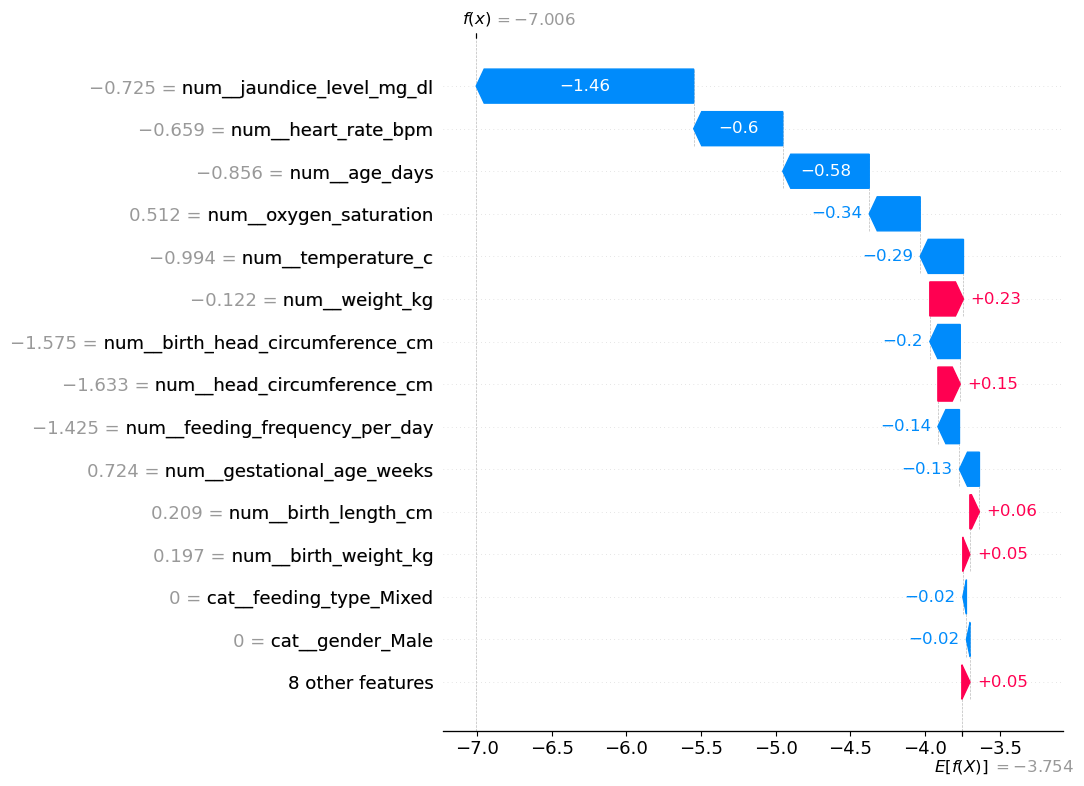

In [6]:
# Keep the 20 training features
X = df[['gender', 'gestational_age_weeks', 'birth_weight_kg', 'birth_length_cm',
        'birth_head_circumference_cm', 'age_days', 'weight_kg', 'length_cm',
        'head_circumference_cm', 'temperature_c', 'heart_rate_bpm',
        'respiratory_rate_bpm', 'oxygen_saturation', 'feeding_type',
        'feeding_frequency_per_day', 'urine_output_count', 'stool_count',
        'jaundice_level_mg_dl', 'immunizations_done', 'reflexes_normal']]

# Extract pipeline parts
preprocess = model.named_steps['preprocess']
clf = model.named_steps['clf']

# Transform full dataset
X_transformed = preprocess.transform(X)
feature_names = preprocess.get_feature_names_out()

# Initialize SHAP explainer on the classifier
explainer = shap.Explainer(clf, X_transformed, feature_names=feature_names)

# Select one instance
instance_index = 7 
x_instance = X_transformed[instance_index:instance_index + 1] 

# Compute SHAP values for that instance
shap_values = explainer(x_instance)

# Waterfall plot
shap.plots.waterfall(shap_values[0], max_display=15)

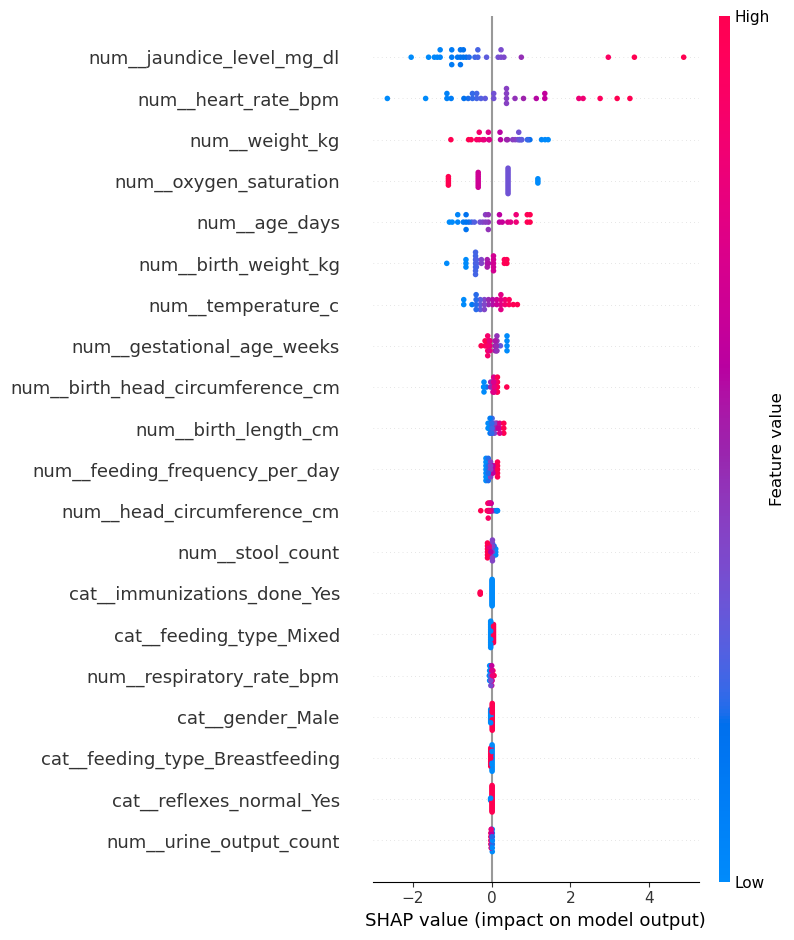

In [7]:
# Selected all False_Negatives
instance_indexes = [7, 43, 54, 58, 66, 69,72,
                    93, 108, 119, 120, 123, 142, 149, 151, 
                   155, 164, 198, 208, 223, 224,261, 319, 336, 338,
                   341, 344, 366, 384]
x_instances = X_transformed[instance_indexes]

# Compute SHAP values 
shap_values = explainer(x_instances)

# Show summary 
shap.summary_plot(shap_values,
                  features=x_instances,
                  feature_names=feature_names)


## <div style="background-color:#0081CC; padding:10px; border-radius:10px; color:white; width:auto;">Exploratory Data Analysis</div>

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2100 entries, 0 to 2099
Data columns (total 25 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   baby_id                      2100 non-null   object 
 1   name                         2100 non-null   object 
 2   gender                       2100 non-null   object 
 3   gestational_age_weeks        2100 non-null   float64
 4   birth_weight_kg              2100 non-null   float64
 5   birth_length_cm              2100 non-null   float64
 6   birth_head_circumference_cm  2100 non-null   float64
 7   date                         2100 non-null   object 
 8   age_days                     2100 non-null   int64  
 9   weight_kg                    2100 non-null   float64
 10  length_cm                    2100 non-null   float64
 11  head_circumference_cm        2100 non-null   float64
 12  temperature_c                2100 non-null   float64
 13  heart_rate_bpm    

In [9]:
df = df.drop(columns=['baby_id', 'name', 'date', 'apgar_score'])

array([[<Axes: title={'center': 'gestational_age_weeks'}>,
        <Axes: title={'center': 'birth_weight_kg'}>,
        <Axes: title={'center': 'birth_length_cm'}>,
        <Axes: title={'center': 'birth_head_circumference_cm'}>],
       [<Axes: title={'center': 'age_days'}>,
        <Axes: title={'center': 'weight_kg'}>,
        <Axes: title={'center': 'length_cm'}>,
        <Axes: title={'center': 'head_circumference_cm'}>],
       [<Axes: title={'center': 'temperature_c'}>,
        <Axes: title={'center': 'heart_rate_bpm'}>,
        <Axes: title={'center': 'respiratory_rate_bpm'}>,
        <Axes: title={'center': 'oxygen_saturation'}>],
       [<Axes: title={'center': 'feeding_frequency_per_day'}>,
        <Axes: title={'center': 'urine_output_count'}>,
        <Axes: title={'center': 'stool_count'}>,
        <Axes: title={'center': 'jaundice_level_mg_dl'}>]], dtype=object)

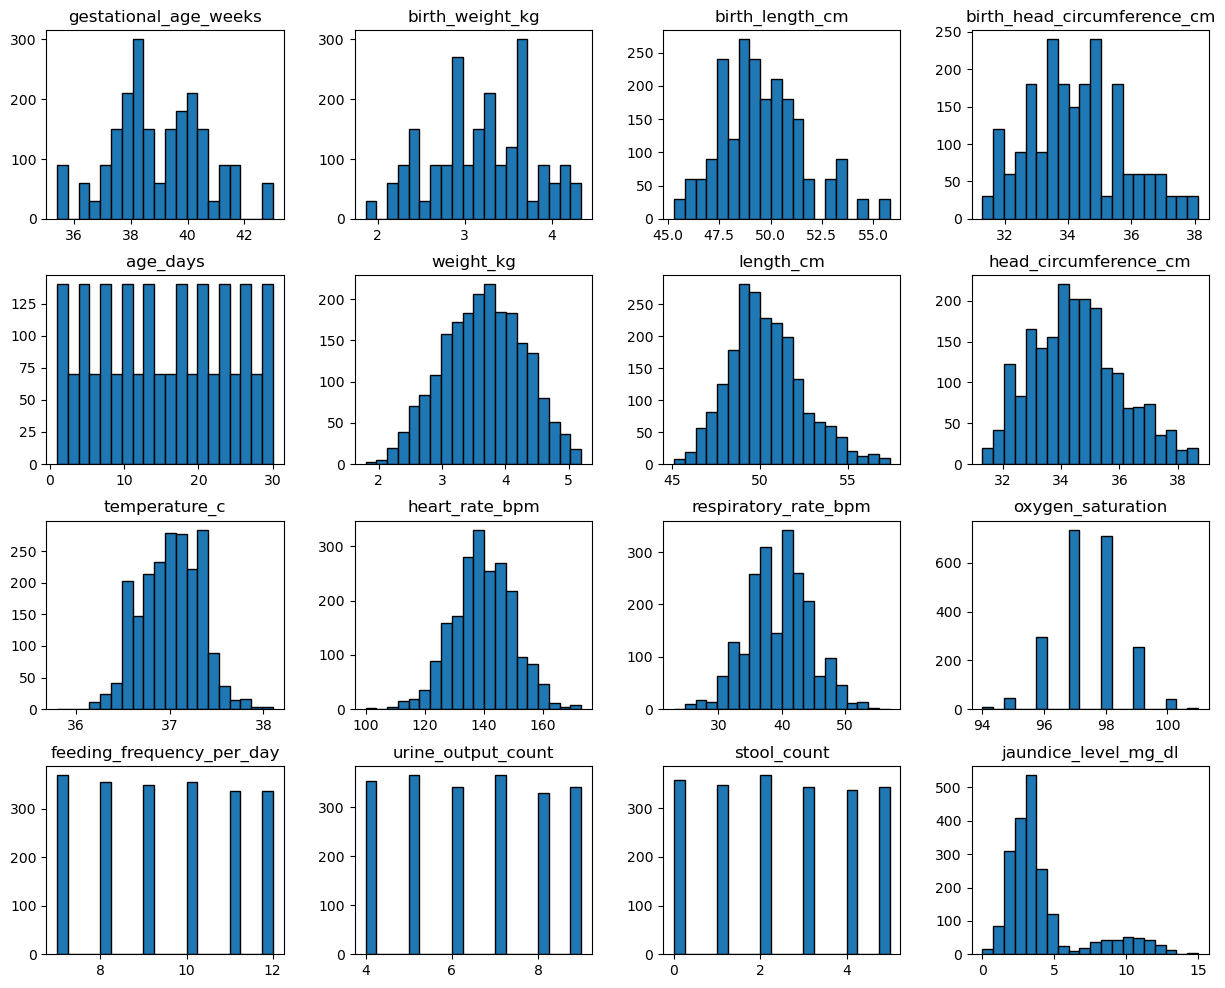

In [10]:
numeric_df = df.select_dtypes(include=['float64','int64'])

numeric_df.hist(
    figsize=(15,12),
    bins= 20,
    edgecolor='black',
    grid=False,
)

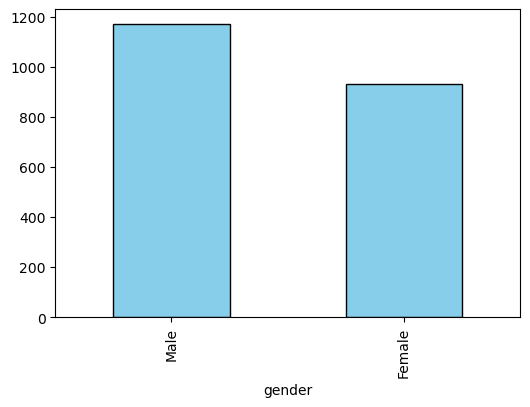

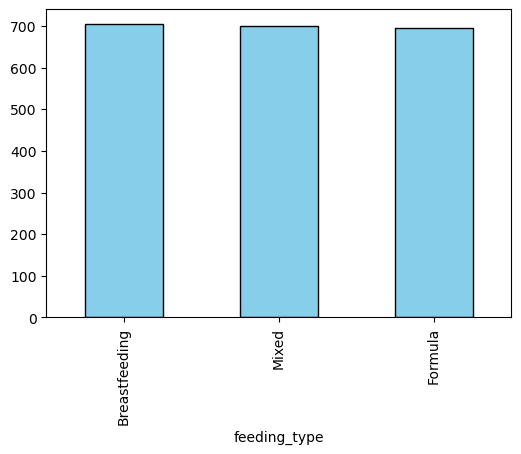

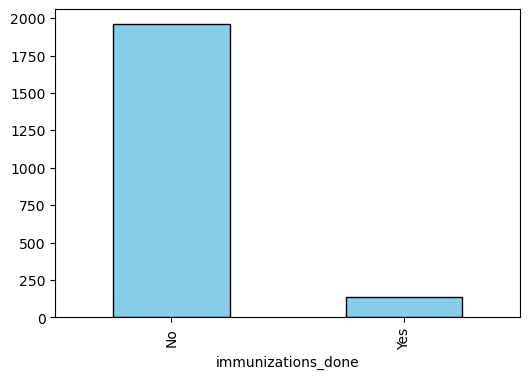

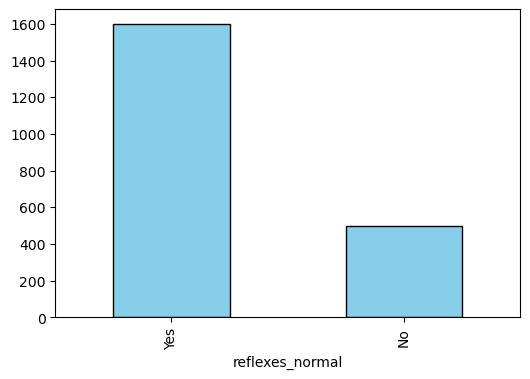

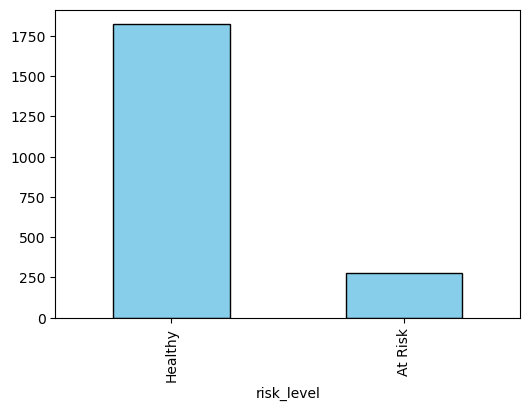

In [11]:
non_numeric_df = df.select_dtypes(exclude=['number'])

for col in non_numeric_df.columns:
    plt.figure(figsize=(6,4))
    non_numeric_df[col].value_counts(dropna=False).plot(kind='bar', color='skyblue', edgecolor='black')
    plt.show()

## <div style="background-color:#0081CC; padding:10px; border-radius:10px; color:white; width:auto;">Pre-processing and Modeling</div>

In [12]:
binary_features = ['gender', 'immunizations_done', 'reflexes_normal']

# Convert to numeric binary columns
for col in binary_features:
    df[col] = df[col].astype(str).str.lower().map({
        'yes': 1, 'male': 1,
        'no': 0,'female': 0
    }).fillna(0).astype(int)

In [49]:
# ----------- STEP 1: Define Feature Types -----------

numerical_features = ['gestational_age_weeks', 'birth_weight_kg', 'birth_length_cm',
                     'birth_length_cm', 'birth_head_circumference_cm', 'age_days', 'weight_kg', 'length_cm',
                     'head_circumference_cm', 'temperature_c', 'heart_rate_bpm', 'respiratory_rate_bpm',
                     'oxygen_saturation', 'feeding_frequency_per_day','urine_output_count','stool_count',
                     'jaundice_level_mg_dl']

categorical_features = ['feeding_type']  # to be one-hot encoded
binary_features = ['gender','immunizations_done', 'reflexes_normal']  # already binary, leave as-is

# ----------- STEP 2: Define Features and Target -----------

X = df.drop(columns=['risk_level'])
y = df['risk_level'].replace({'Healthy': 0, 'At Risk': 1}).values

# ----------- STEP 3: Preprocessing Pipeline -----------

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('bin', 'passthrough', binary_features)  # binary features are left untouched
    ]
)

# ----------- STEP 4: Model Evaluation Setup -----------

models = {
 
    'LogReg (L2)': LogisticRegression(penalty='l2', max_iter=1000, solver='liblinear', random_state=42, class_weight = 'balanced'),
    'LogReg (L1)': LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear', random_state=42, class_weight = 'balanced'),
    
}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

# ----------- STEP 5: Cross-validation Evaluation (with Train Accuracy) -----------

for name, model in models.items():
    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('clf', model)
    ])
    
    train_acc_scores, test_acc_scores = [], []
    prec_scores, rec_scores = [], []

    for train_idx, test_idx in kfold.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        try:
            pipe.fit(X_train, y_train)

            # Predict on train and test
            y_train_pred = pipe.predict(X_train)
            y_test_pred = pipe.predict(X_test)

            # Compute scores
            train_acc_scores.append(accuracy_score(y_train, y_train_pred))
            test_acc_scores.append(accuracy_score(y_test, y_test_pred))
            prec_scores.append(precision_score(y_test, y_test_pred))
            rec_scores.append(recall_score(y_test, y_test_pred))
        except Exception as e:
             print(f"Error in {name}: {e}")

    results.append({
        'Model': name,
        'Test Accuracy': np.nanmean(test_acc_scores),
        'Precision': np.nanmean(prec_scores),
        'Recall': np.nanmean(rec_scores)
    })

# ----------- STEP 6: Show Results -----------

results_df = pd.DataFrame(results).sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True)
print(results_df)

/tmp/ipykernel_42863/1201971534.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['risk_level'].replace({'Healthy': 0, 'At Risk': 1}).values


         Model  Test Accuracy  Precision    Recall
0  LogReg (L2)       0.870952   0.511498  0.837987
1  LogReg (L1)       0.870476   0.510514  0.837987


In [54]:
# OLD
# ----------- STEP 1: Choose the best trained model -----------
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

pipe = Pipeline([
        ('preprocess', preprocessor),
        ('clf', best_model)
    ])

pipe.fit(X_train, y_train)

# ----------- STEP 2: Select rows to visualize -----------
indexes_to_explain = [7, 43, 54, 58, 66, 69, 72, 93, 108, 119, 120, 123,
                      142, 149, 151, 155, 164, 198, 208, 223, 224, 261,
                      319, 336, 338, 341, 344, 366, 384]

X_selected = X_train.iloc[indexes_to_explain]

# ----------- STEP 3: Compute SHAP values (Logistic Regression uses LinearExplainer) -----------
explainer = shap.LinearExplainer(best_model, X_train, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_selected)

# ----------- STEP 4: Get feature names -----------
num_features = preprocessor.named_transformers_['num'].get_feature_names_out(numerical_features)
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
bin_features = binary_features
all_features = np.concatenate([num_features, cat_features, bin_features])

# ----------- STEP 5: Beeswarm plot for selected samples -----------
plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values,
    X_selected,
    feature_names=all_features,
    plot_size=(8, 6),
    show=True
)

/opt/conda/lib/python3.12/site-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


TypeError: unsupported operand type(s) for /: 'str' and 'int'

/opt/conda/lib/python3.12/site-packages/shap/explainers/_linear.py:95: FutureWarning: The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, maskers.Partition or maskers.Impute).
  warnings.warn(wmsg, FutureWarning)


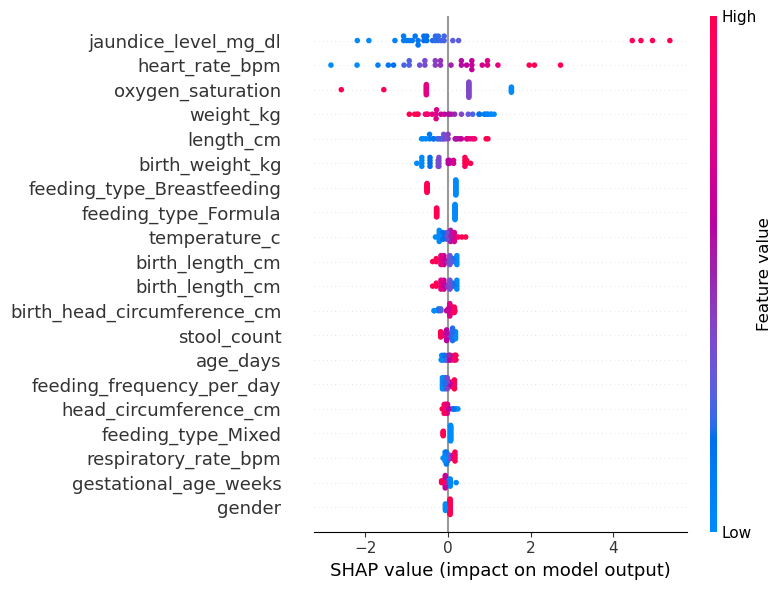

In [55]:
# ----------- STEP 1: Choose the best trained model -----------
best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]

pipe = Pipeline([
    ('preprocess', preprocessor),
    ('clf', best_model)
])

pipe.fit(X_train, y_train)

# ----------- STEP 2: Select rows to visualize -----------
indexes_to_explain = [7, 43, 54, 58, 66, 69, 72, 93, 108, 119, 120, 123,
                      142, 149, 151, 155, 164, 198, 208, 223, 224, 261,
                      319, 336, 338, 341, 344, 366, 384]

X_selected = X_train.iloc[indexes_to_explain]

# ----------- STEP 3: Compute SHAP values -----------
# Transform X into numeric form using the preprocessor
X_train_transformed = pipe.named_steps['preprocess'].transform(X_train)
X_selected_transformed = pipe.named_steps['preprocess'].transform(X_selected)

# Get the actual classifier (after preprocessing)
model_for_shap = pipe.named_steps['clf']

# Create the explainer using the transformed data
explainer = shap.LinearExplainer(model_for_shap, X_train_transformed, feature_perturbation="interventional")
shap_values = explainer.shap_values(X_selected_transformed)

# ----------- STEP 4: Get feature names -----------
num_features = preprocessor.named_transformers_['num'].get_feature_names_out(numerical_features)
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
bin_features = binary_features
all_features = np.concatenate([num_features, cat_features, bin_features])

# ----------- STEP 5: Beeswarm plot for selected samples -----------
plt.figure(figsize=(8, 6))
shap.summary_plot(
    shap_values,
    X_selected_transformed,
    feature_names=all_features,
    plot_size=(8, 6),
    show=True
)


In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline

# ----------- STEP 1: Define Feature Types -----------

numerical_features = ['gestational_age_weeks', 'birth_weight_kg', 'birth_length_cm',
                     'birth_length_cm', 'birth_head_circumference_cm', 'age_days', 'weight_kg', 'length_cm',
                     'head_circumference_cm', 'temperature_c', 'heart_rate_bpm', 'respiratory_rate_bpm',
                     'oxygen_saturation', 'feeding_frequency_per_day','urine_output_count','stool_count',
                     'jaundice_level_mg_dl']

categorical_features = ['feeding_type']  # to be one-hot encoded
binary_features = ['gender','immunizations_done', 'reflexes_normal']  # already binary, leave as-is

# ----------- STEP 2: Define Features and Target -----------

X = df.drop(columns=['risk_level'])
y = df['risk_level'].replace({'Healthy': 0, 'At Risk': 1}).values


# ----------- STEP 3: Preprocessing Pipeline -----------

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('bin', 'passthrough', binary_features)  # binary features are left untouched
    ]
)

# ----------- STEP 4: Model Evaluation Setup -----------

models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, class_weight = 'balanced'),
    'Decision Tree': DecisionTreeClassifier(random_state=42, class_weight = 'balanced')
}

kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

# ----------- STEP 5: Cross-validation Evaluation (with Train Accuracy) -----------

for name, model in models.items():
    pipe = Pipeline([
        ('preprocess', preprocessor),
        ('clf', model)
    ])
    
    train_acc_scores, test_acc_scores = [], []
    prec_scores, rec_scores = [], []

    for train_idx, test_idx in kfold.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        try:
            pipe.fit(X_train, y_train)

            # Predict on train and test
            y_train_pred = pipe.predict(X_train)
            y_test_pred = pipe.predict(X_test)

            # Compute scores
            train_acc_scores.append(accuracy_score(y_train, y_train_pred))
            test_acc_scores.append(accuracy_score(y_test, y_test_pred))
            prec_scores.append(precision_score(y_test, y_test_pred))
            rec_scores.append(recall_score(y_test, y_test_pred))
        except Exception as e:
             print(f"Error in {name}: {e}")

    results.append({
        'Model': name,
        'Train Accuracy': np.nanmean(train_acc_scores),
        'Test Accuracy': np.nanmean(test_acc_scores),
        'Precision': np.nanmean(prec_scores),
        'Recall': np.nanmean(rec_scores)
    })

# ----------- STEP 6: Show Results -----------

results_df = pd.DataFrame(results).sort_values(by='Test Accuracy', ascending=False).reset_index(drop=True)
print(results_df)

/tmp/ipykernel_42863/231053322.py:29: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = df['risk_level'].replace({'Healthy': 0, 'At Risk': 1}).values


           Model  Train Accuracy  Test Accuracy  Precision    Recall
0  Decision Tree             1.0       0.999048        1.0  0.992857
1  Random Forest             1.0       0.998571        1.0  0.989286


In [28]:
dt_model = DecisionTreeClassifier(random_state=42, class_weight = 'balanced')

from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_model, X_processed, y, cv=5, scoring='f1')
print("CV Mean:", scores.mean(), "±", scores.std())


CV Mean: 1.0 ± 0.0


In [33]:
help = Pipeline([
    ('preprocess', preprocessor),
    ('clf', dt_model)
])

help.fit(X_train, y_train)


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['gestational_age_weeks',
                                                   'birth_weight_kg',
                                                   'birth_length_cm',
                                                   'birth_length_cm',
                                                   'birth_head_circumference_cm',
                                                   'age_days', 'weight_kg',
                                                   'length_cm',
                                                   'head_circumference_cm',
                                                   'temperature_c',
                                                   'heart_rate_bpm',
                                                   'respiratory_rate_bpm',
                                                   'oxygen_saturation',
                                                   'feeding_frequency_per_day',
                                                   'urine_output_count',
                                                   'stool_count',
                                                   'jaundice_level_mg_dl']),
                                                 ('cat', OneHotEncoder(),
                                                  ['feeding_type']),
                                                 ('bin', 'passthrough',
                                                  ['gender',
                                                   'immunizations_done',
                                                   'reflexes_normal'])])),
                ('clf',
                 DecisionTreeClassifier(class_weight='balanced',
                                        random_state=42))])

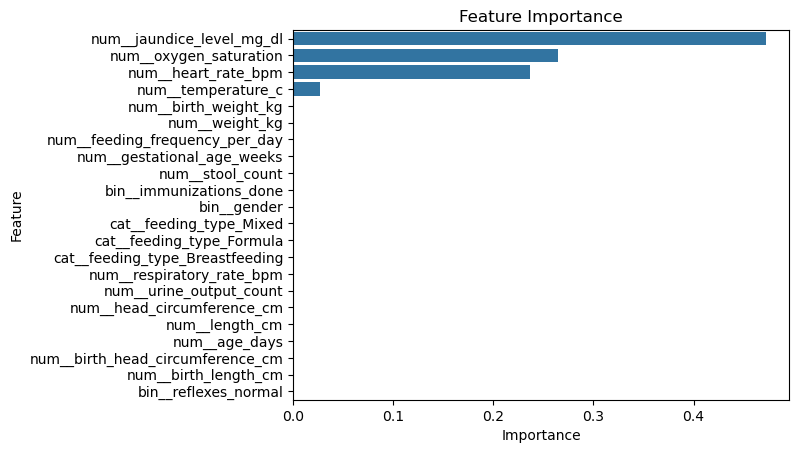

In [37]:
FEATURE_NAMES_NEW = preprocessor.get_feature_names_out()
feature_importances = dt_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': FEATURE_NAMES_NEW,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()

In [40]:
X.columns

Index(['gender', 'gestational_age_weeks', 'birth_weight_kg', 'birth_length_cm',
       'birth_head_circumference_cm', 'age_days', 'weight_kg', 'length_cm',
       'head_circumference_cm', 'temperature_c', 'heart_rate_bpm',
       'respiratory_rate_bpm', 'oxygen_saturation', 'feeding_type',
       'feeding_frequency_per_day', 'urine_output_count', 'stool_count',
       'jaundice_level_mg_dl', 'immunizations_done', 'reflexes_normal'],
      dtype='object')

In [45]:
# Drop top 1 or 2 features
X_drop = X.drop(columns=["jaundice_level_mg_dl", "oxygen_saturation"])
numerical_features = ['gestational_age_weeks', 'birth_weight_kg', 'birth_length_cm',
                     'birth_length_cm', 'birth_head_circumference_cm', 'age_days', 'weight_kg', 'length_cm',
                     'head_circumference_cm', 'temperature_c', 'heart_rate_bpm', 'respiratory_rate_bpm',
                     'feeding_frequency_per_day','urine_output_count','stool_count']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('bin', 'passthrough', binary_features)  # binary features are left untouched
    ]
)

# Re-run cross-validation
from sklearn.pipeline import Pipeline
pipe = Pipeline([("preprocessor", preprocessor),
                 ("clf", DecisionTreeClassifier(random_state=42, class_weight = 'balanced'))])

scores = cross_validate(pipe, X_drop, y, cv=5, scoring="accuracy", return_train_score=True)
print("Train:", scores['train_score'].mean(), "Test:", scores['test_score'].mean())


Train: 1.0 Test: 0.8695238095238095


In [48]:
# Drop top 1 or 2 features
X_drop = X.drop(columns=["jaundice_level_mg_dl", "oxygen_saturation"])
numerical_features = ['gestational_age_weeks', 'birth_weight_kg', 'birth_length_cm',
                     'birth_length_cm', 'birth_head_circumference_cm', 'age_days', 'weight_kg', 'length_cm',
                     'head_circumference_cm', 'temperature_c', 'heart_rate_bpm', 'respiratory_rate_bpm',
                     'feeding_frequency_per_day','urine_output_count','stool_count']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features),
        ('bin', 'passthrough', binary_features)  # binary features are left untouched
    ]
)

# Re-run cross-validation
from sklearn.pipeline import Pipeline
pipe = Pipeline([("preprocessor", preprocessor),
                 ("clf", RandomForestClassifier(n_estimators=100, random_state=42, class_weight = 'balanced'))])

scores = cross_validate(pipe, X_drop, y, cv=5, scoring="accuracy", return_train_score=True)
print("Train:", scores['train_score'].mean(), "Test:", scores['test_score'].mean())


Train: 1.0 Test: 0.8942857142857144


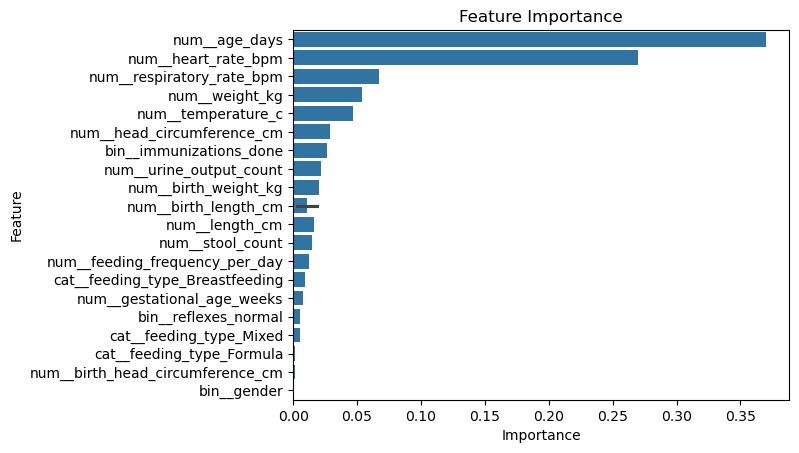

In [47]:
dt_model = DecisionTreeClassifier(random_state=42, class_weight = 'balanced')

help = Pipeline([
    ('preprocess', preprocessor),
    ('clf', dt_model)
])

help.fit(X_train, y_train)

FEATURE_NAMES_NEW = preprocessor.get_feature_names_out()
feature_importances = dt_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': FEATURE_NAMES_NEW,
    'Importance': feature_importances
})

feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importance')
plt.show()